# Model V5 XNLI

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

In [2]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation

In [3]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [4]:
# CHECK GPU hardware

!nvidia-smi

Tue Jun 13 17:04:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:3B:00.0 Off |                  Off |
| 30%   24C    P8    18W / 230W |      0MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Evaluation in generated test set

## Model's predictions

Load model

In [4]:
from data_module.fr_xnli_module import FrXNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm_xnli = FrXNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8)
dm_xnli.prepare_data()
dm_xnli.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'xnli/run=0_vector=fasttext'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm_xnli.vocab,
    concat_context=True,
    data='archival',
    num_class=dm_xnli.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

19-06-2023 09:41:30 |     INFO   fr_xnli_module.py:prepare_data:107  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/xnli/fr/vocab.pt
19-06-2023 09:41:30 |     INFO   fr_xnli_module.py:prepare_data:109  Vocab size: 36154
19-06-2023 09:41:30 |     INFO   pipeline.py:__init__:31  Loaded preprocessed dataset from /srv/tempdd/dunguyen/RUNS/dataset/xnli/fr/pretransformed.test.json
19-06-2023 09:41:31 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
Model is in cuda:  True


In [5]:
# Adapt to collate
dm_xnli.test_set.data = dm_xnli.test_set.data.rename(columns={'premise.norm':'premise.tokens', 'hypothesis.norm': 'hypothesis.tokens'})
                                                    

In [6]:
data = dm_xnli.test_set.data

In [7]:
dm_xnli.setup('train')

Check accuracy

In [12]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm_xnli.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.6226, device='cuda:0')

Precision / Recall curve 

In [27]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

# For entailment class
y_true_ent = all_y_true == 1
y_hat_ent =  all_y_hat[:, 1]

precision, recall, thresholds = precision_recall_curve(y_true_ent.cpu(), y_hat_ent.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
plt.title('Precision and Recall on Entailment', fontsize=18)
#plt.show()
plt.savefig(path.join(tmp_path, 'xnli', 'vector=0_prcurve_entailment.png'), bbox_inches='tight', dpi=300)
plt.clf()



y_true_cont = all_y_true == 2
y_hat_cont =  all_y_hat[:, 2]

precision, recall, thresholds = precision_recall_curve(y_true_cont.cpu(), y_hat_cont.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
plt.title('Precision and Recall on Contradiction', fontsize=18)
#plt.show()


plt.savefig(path.join(tmp_path, 'xnli', 'vector=0_prcurve_contradiction.png'), bbox_inches='tight', dpi=300)
plt.clf()

<Figure size 432x288 with 0 Axes>

Note : 

If consider only entailment pairs : **2947** , If consider only contradiction pairs : **2531**. Total size for test set : **5010**

In [31]:
y_true_ent.shape

torch.Size([2947])

In [33]:
y_true_cont.shape

torch.Size([2531])

In [34]:
all_y_true.shape

torch.Size([5010])

Distribution

In [130]:
plt.rcParams["figure.dpi"] = 200

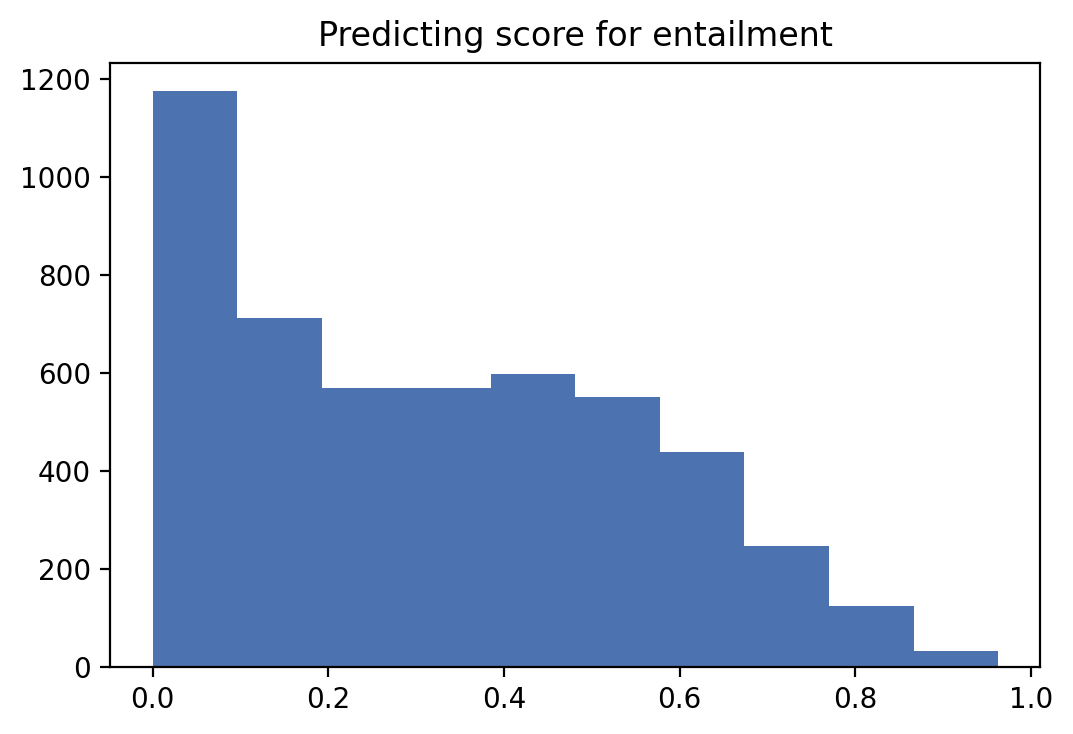

In [157]:
y_score = all_y_hat[:,1].cpu().numpy()

plt.hist(y_score) 
plt.title("Predicting score for entailment") 
plt.show()

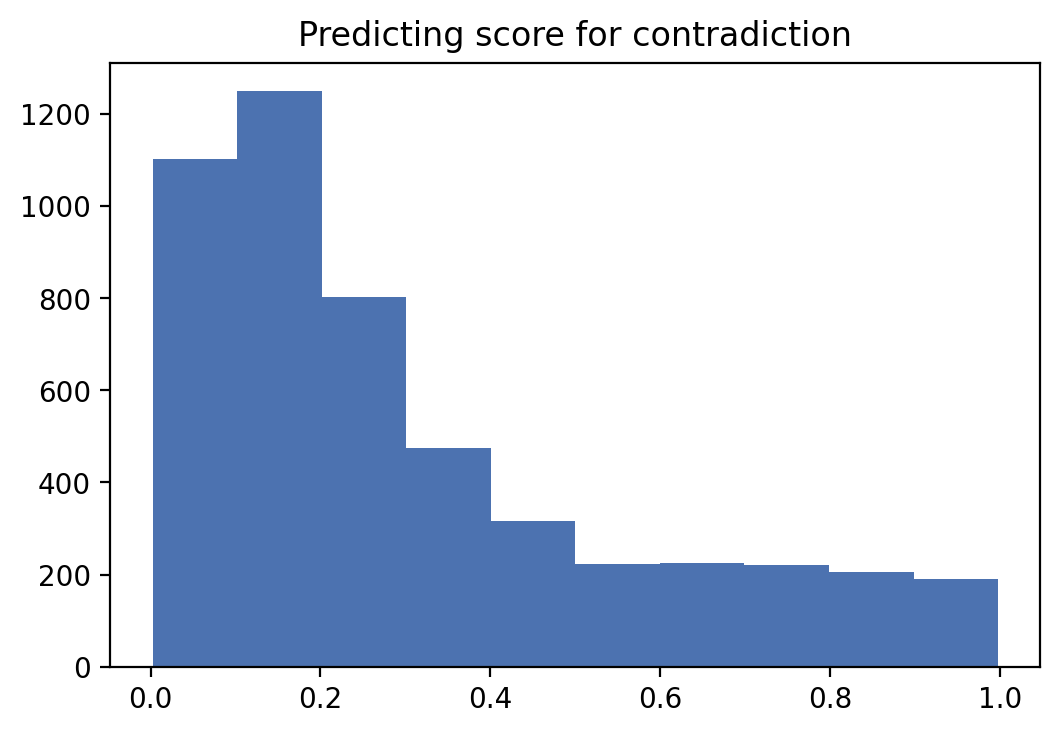

In [150]:
y_score = all_y_hat[:,2].cpu().numpy()

plt.hist(y_score) 
plt.title("Predicting score for contradiction") 
plt.show()

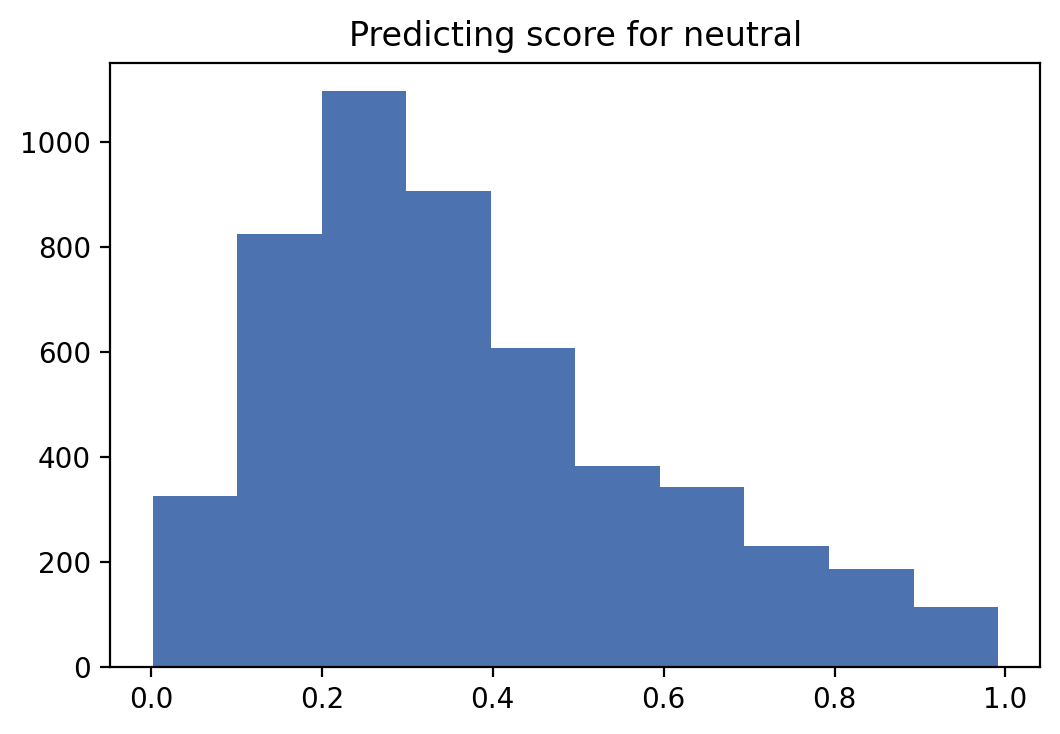

In [151]:
y_score = all_y_hat[:,0].cpu().numpy()

plt.hist(y_score) 
plt.title("Predicting score for neutral") 
plt.show()

In [158]:
import seaborn as sns
colors = sns.color_palette("husl", 2)

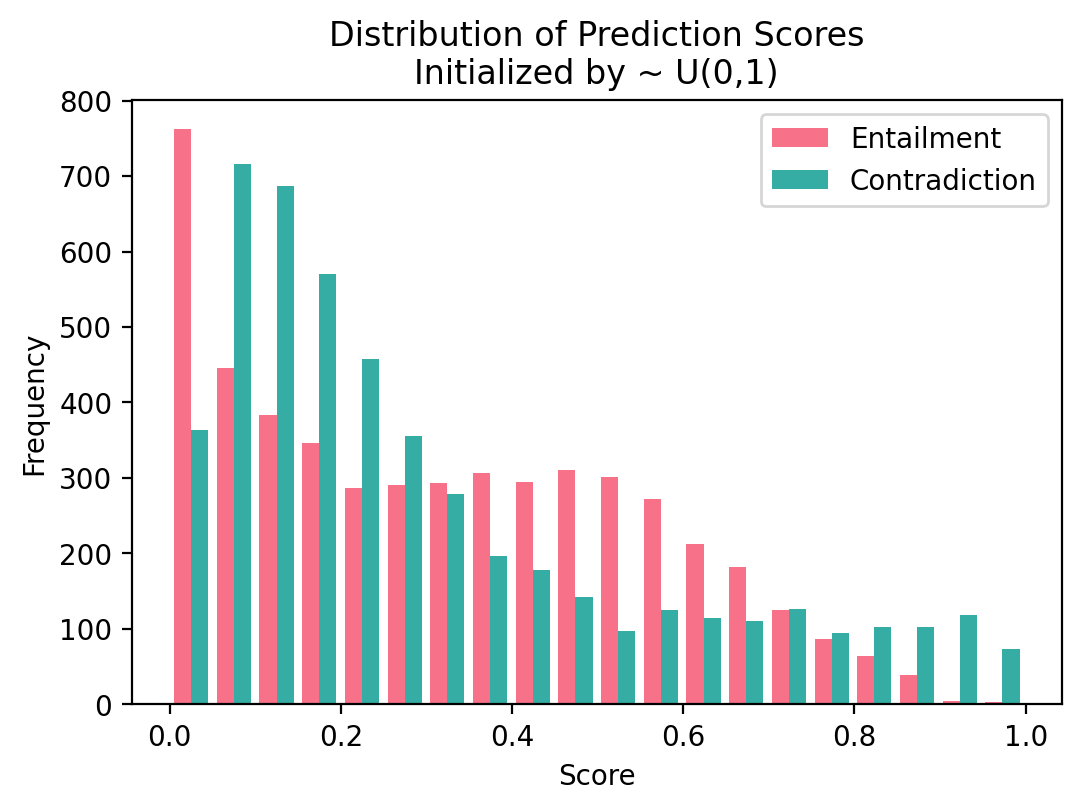

In [148]:
y_score = all_y_hat.cpu().numpy()

plt.hist([y_score[:, 1], y_score[:, 2]], bins=20, label=['Entailment', 'Contradiction'], color=colors)

plt.legend(loc='upper right')
plt.title('Distribution of Prediction Scores\nInitialized by ~ U(0,1)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

What if we consider only both class as the same ?

In [152]:
import torchmetrics as m

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)
    y_hat = torch.stack((y_hat[:, 0], y_hat[:, 1:].sum(dim=1)), dim=1)
    y_hat = y_hat[:,1]
    
    y_true = y_true > 0
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

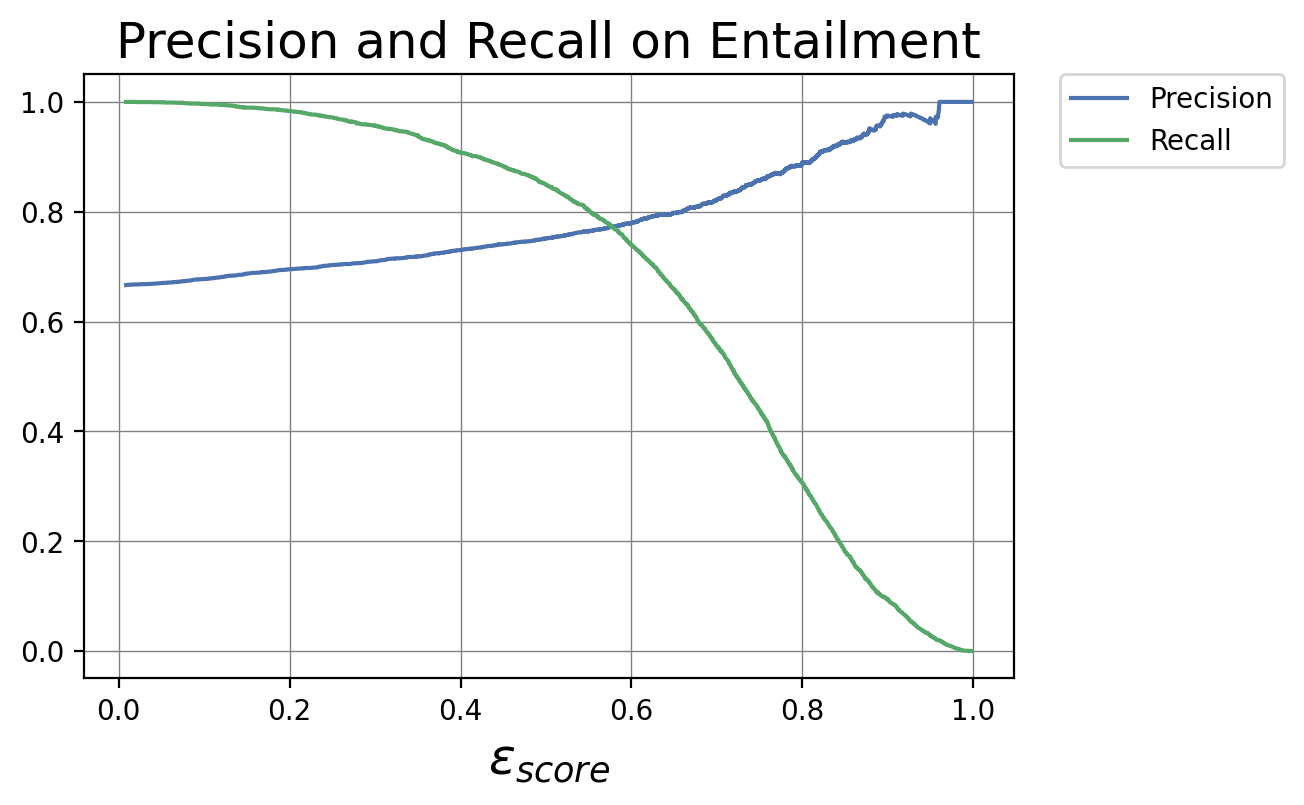

In [153]:
precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall on Entailment', fontsize=18)
plt.show()

### Investigate into cases where precision drop down (near by 1.)

In [80]:
from sklearn.metrics import precision_score

In [73]:
data = dm.test_set.data
data['p_entail'] = all_y_hat.cpu().numpy()[:,1]
data['p_contra'] = all_y_hat.cpu().numpy()[:,2]

In [122]:
data[(0.9 < data['p_entail'])][['premise.text','hypothesis.text','label', 'p_entail']].sort_values(by='p_entail')

,premise.text,hypothesis.text,label,p_entail
4480,Tu lui accordes trop d'importance.,Vous créez quelque chose.,implication,0.902797
2385,Voir la liste des mèches blondes aux pages 82 ...,Il y a une liste de plages.,implication,0.904315
3703,Ce groupe de donateurs aidera directement le C...,Le groupe de donateurs aura un représentant qu...,neutre,0.928039
2994,"Cependant, on peut également prévoir que la vi...",Une visite à l'urgence peut être un outil d'en...,implication,0.934380
928,quand je grandissais euh,Je grandissais.,implication,0.949592
2542,"Ensuite, le même représentant qui a effectué l...",Il y a eu une visite d'un représentant.,implication,0.951974
608,"Oui, profitez bien de l’été !","Oui, passez un été agréable.",implication,0.962286


## Model's attention map

### Inference on Autogestion NLI test set

Note : 

The vocabulary size from **Autogestion** is **12639**.

The vocabulary size from **XNLI** is **36154**.

(both with minimum frequency > 5)

In [13]:
from data_module.archival_module import ArchivalNLIDM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

#######################
# PREPARE DATA ARCHIVAL
#######################
dm_archival = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v2')
dm_archival.prepare_data()
dm_archival.setup('test')
dm_archival.vocab = dm_xnli.vocab

FileNotFoundError: File /srv/tempdd/dunguyen/RUNS/dataset/archival/v2/archival_nli.json does not exist

If we use the model that detect both classes

In [ ]:
import pandas as pd

df_inference = pd.DataFrame()

for batch in dm_archival.test_dataloader():
    y_true = batch['y_true'].to(device)
    padding_mask = batch['padding_mask']
    B = len(y_true)
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {side: a_hat[side].softmax(-1) for side in a_hat}
    a_hat = { side : [ attention[i][~padding_mask[side][i]].tolist()  for i in range(B) ] for side, attention in a_hat.items() }

    inferench_batch = {}
    for side in ['premise', 'hypothesis']:
        COLUMNS = [side + '.norm', side + '.form']
        inferench_batch.update({c : batch[c] for c in COLUMNS})
        inferench_batch.update({side + '.attention' : a_hat[side]})



    inferench_batch['y_true'] = batch['y_true'].tolist()
    inferench_batch['y_score'] = y_hat.tolist()
    
    inferench_batch = pd.DataFrame(inferench_batch)
    
    df_inference = pd.concat([df_inference, inferench_batch])
    
df_inference.reset_index(drop=True, inplace=True)

In [ ]:
EPSILON_Y_HAT = 0.8

df_inference['y_hat'] = df_inference['y_score'] > EPSILON_Y_HAT

df_true_positive = df_inference[df_inference['y_hat'] & df_inference['y_true']]
df_true_positive = df_true_positive.sort_values(by=['y_score'], ascending=False)
df_true_positive.reset_index(drop=True, inplace=True)

print('% True positive:', len(df_true_positive) / len(df_inference))
print('# True positive:', len(df_true_positive))

In [14]:
from modules import highlight
BEGIN = 0
END = 30  

html='<table>'
html += '<thead><tr><th>Index</th> <th>Premise</th> <th>Hypothesis</th> <th>Score</th> </tr></thead>'

for idx, row in df_true_positive[BEGIN:END].iterrows():
    
    idx = str(row.name)
    #premise = [tk['form'] for tk in s_tokens]
    premise = highlight(row['premise.form'], row['premise.attention'])

    #hypothesis = ' '.join([tk['form'] for tk in t_tokens])
    hypothesis = highlight(row['hypothesis.form'], row['hypothesis.attention'])

    score = str(round(row['y_score'], 2))
    
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +premise + '</td>' + '<td>' + hypothesis + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

NameError: name 'df_true_positive' is not defined

Words received most of attention weight

In [ ]:
import numpy as np
import json

ATTENDED_TOKEN_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions', 'words_attention_mass.json')

if path.exists(ATTENDED_TOKEN_PATH):
    
    # Load the attention mass if the file exits
    with open(ATTENDED_TOKEN_PATH, 'r') as f:
        avg_attention_mass = json.load(f)
else:

    # flatten and align tokens and attentions
    tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
    attentions = np.concatenate(df_true_positive['premise.attention'].tolist()).tolist()
    assert len(tokens) == len(attentions), 'Not compatible length'

    # cumulate attention weights
    attention_mass = {}
    word_occurence = {}
    for w, a in zip(tokens, attentions):
        # w : word
        # a : attention weight
        attention_mass[w] = attention_mass.get(w, 0) + a
        word_occurence[w] = word_occurence.get(w, 0) + 1

    # renormalized by the word frequency 
    avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}
        
    # sort by descending order
    avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

    # Save to file
    os.makedirs(path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions'), exist_ok=True)
    with open(ATTENDED_TOKEN_PATH, 'w') as f:
        json.dump(avg_attention_mass, f)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['figure.dpi'] = 300

N_WORDS = 20
x = list(avg_attention_mass.keys())[:N_WORDS]
y = list(avg_attention_mass.values())[:N_WORDS]
plt.barh(x[::-1], y[::-1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'{N_WORDS} most attended words', fontsize=18)

fig_path = path.join(tmp_path, 'figures')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(path.join(fig_path, f'average_attn_mass_xnli.png'),dpi=100)
plt.show()

# Evaluation in a subset

In [ ]:
%%time
import pandas as pd

std_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'std_block_links.json')
df_std_block_links = pd.read_json(std_block_links_path, dtype={'link.type':'category'})

block_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'blocks.v2.json')
df_block = pd.read_json(block_path, encoding='utf-8')

In [11]:
article_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'articles.v2.json')
df_article = pd.read_json(article_path)
df_article.set_index('id', inplace=True)

In [12]:
# Format df_block , create uid index for easy access
df_block['uid'] = df_block['page.id.fmsh'] + '_' + df_block['block.id'].astype(str).str.zfill(2)
df_block = df_block.set_index('uid')

In [13]:
from modules.archival import *
from modules import *


In [14]:
df_block = df_block.rename(columns={'sentences': 'sents'})

## Study on an example link

In [48]:
#Get a link
link = df_std_block_links.iloc[1000]

source_revue_id = link['source.revue.id.persee']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.bloc.id']

# get uid
block_uid = { side: link[f'{side}.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm_xnli, model)

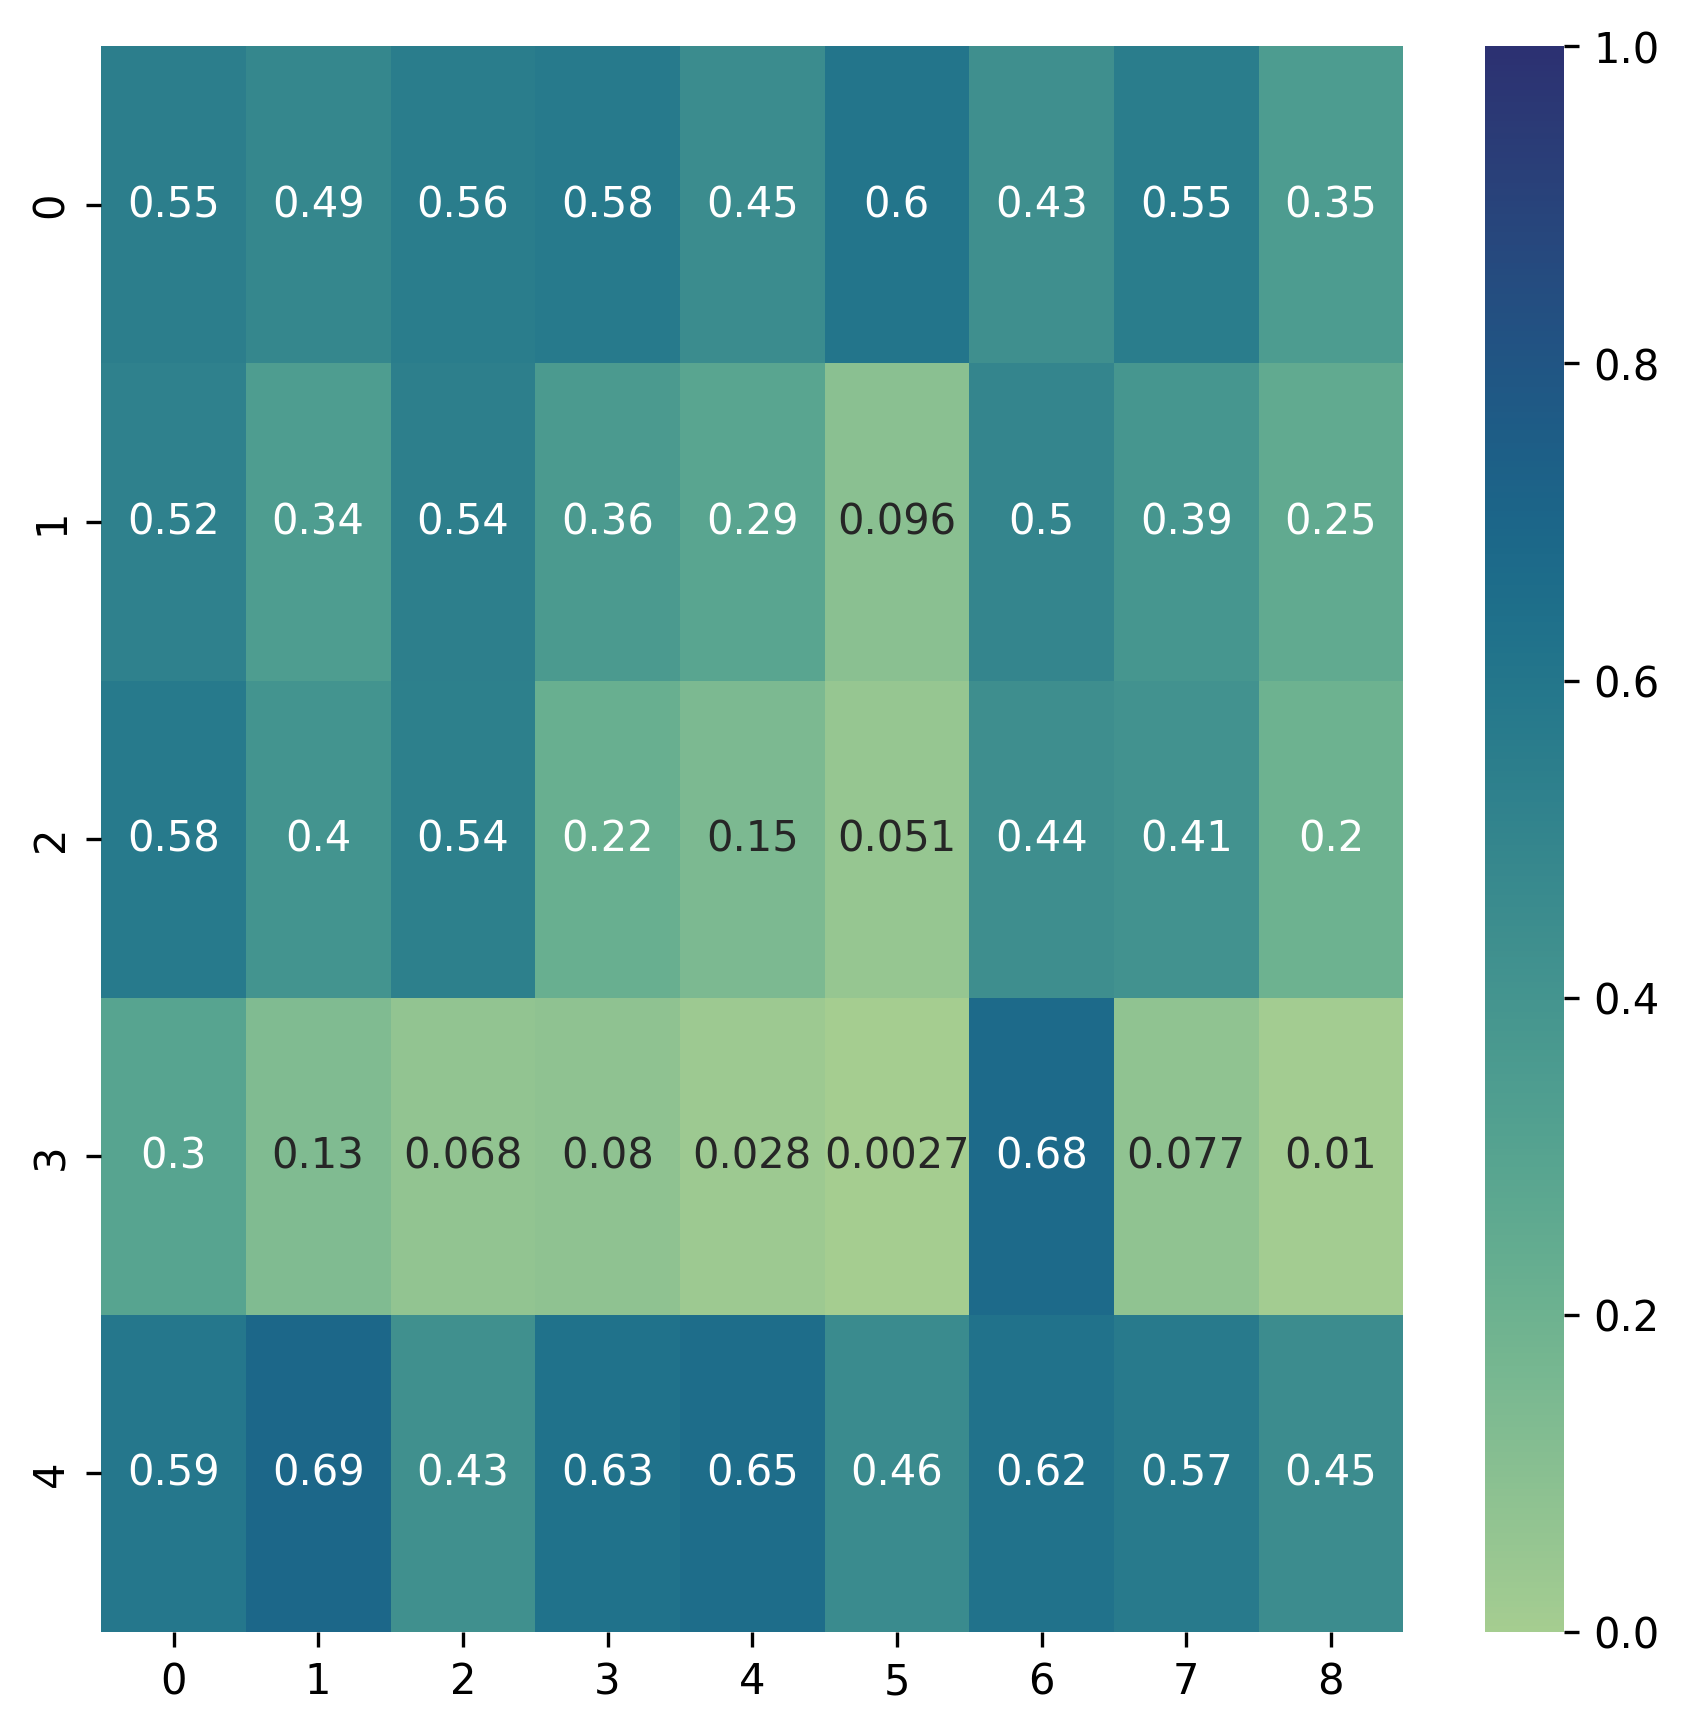

In [49]:
import seaborn as sns
from matplotlib import pyplot as plt

y_score_matrix = inference['y_score_matrix']
ax = sns.heatmap(y_score_matrix, annot=True, vmin=0, vmax=1, cmap="crest")

plt.show()



In [50]:
# Prepare the tokens
block_words = {'source': [], 'target': []}
for side in block_words:
    block_form = get_block(df_block, block_uid[side], 'form')
    block_space = [[(' ' if s else '') for s in sent_s] for sent_s in get_block(df_block, block_uid[side], 'space_after')]
    block_words[side] = [[f+s for f, s in zip(block_f, block_s)] for block_f, block_s in zip(block_form, block_space)]

In [51]:
# get top sentence pairs for better interpretation
inference_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3, above_threshold=0.5)

html = '<table>'
html += f'<caption><strong>{len(inference_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'

for pairs in inference_pairs:
    
    html += '<tr>'
    source_words = block_words['source'][pairs['idx_sent_source']]
    target_words = block_words['target'][pairs['idx_sent_target']]
    
    source_words = highlight(source_words, pairs['attention_source'])
    target_words = highlight(target_words, pairs['attention_target'])
    
    html += '<td>'+ source_words + ' '+ '<u>' + target_words + '</u>' +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

In [52]:
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.5, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.5)

def article_identity(df_article, article_id):
    """Reformat identity for article"""
    authors = df_article.loc[article_id,'authors']
    if len(authors) == 1:
        authors = authors[0]
    else:
        ', '.join(authors)
    year = df_article.loc[article_id,'publicationYear'].astype(str)
    title = df_article.loc[article_id,'title']
    return authors + '. ' + year + '. "' +  title + '"'

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'

source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
source_identity = article_identity(df_article, source_article_id)
target_identity = article_identity(df_article, target_article_id)

html += '<thead><tr><th>Source : '+source_identity+'</th> <th>Target : '+target_identity+'</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'


# Prepare the tokens
flat_block_words = {
    side : [token for sentence in block_words[side] for token in sentence] for side in block_words
}

flat_block_attention = { 
    side: [att for sentence in block_attentions[side] for att in sentence] for side in block_words
}

# First line : block text + score + type
html += '<tr>'

html += '<td>'+ highlight(flat_block_words['source'], flat_block_attention['source'])+ '</td>'
html += '<td>'+ highlight(flat_block_words['target'], flat_block_attention['target'])+ '</td>'

# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

html += '</tbody>'
html += '</table>'
display(HTML(html))



## Study on most likely to be entailment and contradiction

In [ ]:
sentences = df_block.iloc[800]['sents']
premise = [token['norm'] for token in sentences[0]]

premise_form = ''.join([token['form'] + token['_space_after'] for token in sentences[0]])
print('Premise :')
print(premise_form)
print('ConLL Tokens :')
print(premise)


sentences = df_block['sents'].tolist()
sentences = [s for sent in sentences for s in sent]
sentences = df_block.sample(n=1000)['sents'].tolist()
sentences = [s for sent in sentences for s in sent]
hypothesises = [[token['norm'] for token in sent] for sent in sentences]

dataset = pd.DataFrame({
    'premise.tokens': [premise] * len(hypothesises),
    'hypothesis.tokens': hypothesises,
})

In [ ]:
from tqdm.auto import tqdm
dm_xnli.test_set.data = dataset

all_y_score = []
all_attention = {
    'premise': [], 'hypothesis':[]
}
tokens_from_vocab = {
    'premise': [], 'hypothesis':[]
}

results = {
    'p_entail': [],
    'p_contra': [],
    'premise.tokens.xnli' : [],
    'hypothesis.tokens.xnli' : [],
    'premise.attention' : [],
    'hypothesis.attention' : [],
}

def batch_lookup_tokens(vocab, batch_ids):
    batch_ids = batch_ids.tolist()
    return [dm_xnli.vocab.lookup_tokens(ids) for ids in batch_ids]


if path.exists('xnli_study.json'):
    df = pd.read_json('xnli_study.json')
else:

    with torch.no_grad():
        for batch in tqdm(dm_xnli.test_dataloader()):
            y_score, attentions = model(
                premise_ids=batch['premise.ids'].to(model.device), 
                hypothesis_ids=batch['hypothesis.ids'].to(model.device), 
                premise_padding=batch['padding_mask']['premise'].to(model.device), 
                hypothesis_padding=batch['padding_mask']['hypothesis'].to(model.device)
            )

            y_score = y_score.softmax(-1).cpu().numpy()
            attentions = {side : a.softmax(-1).cpu().numpy() for side, a in attentions.items()}

            xnli_tokens = {
                'premise': batch_lookup_tokens(dm_xnli.vocab, batch['premise.ids']),
                'hypothesis' : batch_lookup_tokens(dm_xnli.vocab, batch['hypothesis.ids'])
            }

            attentions['premise'] = [a[~m].tolist() for a, m in zip(attentions['premise'], batch['padding_mask']['premise'])]
            attentions['hypothesis'] = [a[~m].tolist() for a, m in zip(attentions['hypothesis'], batch['padding_mask']['hypothesis'])]

            results['p_entail'].extend(y_score[:,1].tolist())
            results['p_contra'].extend(y_score[:,2].tolist())
            results['premise.attention'].extend(attentions['premise'])
            results['hypothesis.attention'].extend(attentions['hypothesis'])

            results['premise.tokens.xnli'].extend( xnli_tokens['premise'])
            results['hypothesis.tokens.xnli'].extend(xnli_tokens['hypothesis'])

    df = pd.concat([dataset, pd.DataFrame(results)], axis=1)
    df.to_json('xnli_study.json')
    
df

In [ ]:
topk = 10
display(HTML(f'<b>{topk} highest entailment score</b>'))

html = '<table>'

#########
# HEADER
#########

sep = ' &rArr; '

html += '<tr>'
html += '<th>Premise</th> <th>Hypoethesis</th><th>Score</th>'
html += '</tr>'



for dix, row in df.sort_values(by='p_entail', ascending=False)[:topk].iterrows():
    html += '<tr>' 
    
    html += '<td>'
    html += highlight(row['premise.tokens.xnli'], row['premise.attention'])
    #html += ' '.join(row['premise.tokens'])
    #html += sep
    html += '</td>'
    
    html += '<td>'
    html += highlight(row['hypothesis.tokens.xnli'], row['hypothesis.attention'])
    #html += '<u>' + ' '.join(row['hypothesis.tokens']) + '</u>'
    html += '</td>'

    html += '<td>' + str(round(row['p_entail'],2)) + '</td>'
    
    html += '</tr>'
    
html += '</table>'

display(HTML(html))

In [ ]:
topk = 10
display(HTML(f'<b>{topk} lowest entailment score</b>'))

html = '<table>'

#########
# HEADER
#########

sep = ' &rArr; '

html += '<tr>'
html += '<th>Premise</th> <th>Hypoethesis</th><th>Score</th>'
html += '</tr>'



for dix, row in df.sort_values(by='p_entail', ascending=True)[:10].iterrows():
    html += '<tr>' 
    
    html += '<td>'
    html += highlight(row['premise.tokens.xnli'], row['premise.attention'])
    #html += ' '.join(row['premise.tokens'])
    #html += sep
    html += '</td>'
    
    html += '<td>'
    html += highlight(row['hypothesis.tokens.xnli'], row['hypothesis.attention'])
    #html += '<u>' + ' '.join(row['hypothesis.tokens']) + '</u>'
    html += '</td>'

    html += '<td>' + str(round(row['p_entail'],2)) + '</td>'
    
    html += '</tr>'
    
html += '</table>'

display(HTML(html))

In [ ]:
topk = 10
display(HTML(f'<b>{topk} highest contradiction score</b>'))

html = '<table>'

#########
# HEADER
#########

sep = ' &rArr; '

html += '<tr>'
html += '<th>Premise</th> <th>Hypoethesis</th><th>Score</th>'
html += '</tr>'



for dix, row in df.sort_values(by='p_contra', ascending=False)[:topk].iterrows():
    html += '<tr>' 
    
    html += '<td>'
    html += highlight(row['premise.tokens.xnli'], row['premise.attention'])
    #html += ' '.join(row['premise.tokens'])
    #html += sep
    html += '</td>'
    
    html += '<td>'
    html += highlight(row['hypothesis.tokens.xnli'], row['hypothesis.attention'])
    #html += '<u>' + ' '.join(row['hypothesis.tokens']) + '</u>'
    html += '</td>'

    html += '<td>' + str(round(row['p_contra'],2)) + '</td>'
    
    html += '</tr>'
    
html += '</table>'

display(HTML(html))

In [ ]:
topk = 10
display(HTML(f'<b>{topk} highest entailment score</b>'))

html = '<table>'

#########
# HEADER
#########

html += '<tr>'
html += '<th>Premise &rArr; Hypoethesis</th><th>Score</th>'
html += '</tr>'

sep = '&rArr;'

for dix, row in dataset.sort_values(by='p_entail', ascending=False)[:topk].iterrows():
    html += '<tr>' 
    
    html += '<td>'
    html += ' '.join(row['premise.tokens'])
    #html += sep
    html += '<u>' + ' '.join(row['hypothesis.tokens']) + '</u>'
    html += '</td>'

    html += '<td>' + str(round(row['p_entail'],2)) + '</td>'
    
    html += '</tr>'
    
html += '</table>'

display(HTML(html))

In [10]:
dataset['p_entail'].hist()

NameError: name 'dataset' is not defined

In [ ]:
# flatten and align tokens and attentions
tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
attentions = np.concatenate(df_true_positive['premise.attention'].tolist()).tolist()
assert len(tokens) == len(attentions), 'Not compatible length'

# cumulate attention weights
attention_mass = {}
word_occurence = {}
for w, a in zip(tokens, attentions):
    # w : word
    # a : attention weight
    attention_mass[w] = attention_mass.get(w, 0) + a
    word_occurence[w] = word_occurence.get(w, 0) + 1

# renormalized by the word frequency 
avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}

# sort by descending order
avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

# Save to file
os.makedirs(path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions'), exist_ok=True)
with open(ATTENDED_TOKEN_PATH, 'w') as f:
    json.dump(avg_attention_mass, f)